In [1]:
import pretty_midi
import numpy as np
import joblib
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
import matplotlib.gridspec
import collections
import os
import math

import pandas as pd

from sklearn import datasets 
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 


In [2]:
def plot_data(x, y): 
    fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.scatter(x, y, marker='_')
    plt.xlabel('Time (x0.01 s)')
    plt.ylabel('MIDI Pitch')
#     plt.ylim(top=384)
    plt.show()

In [40]:
def compute_statistics(midi_file):
    """
    Given a path to a MIDI file, compute a dictionary of statistics about it
    
    Parameters
    ----------
    midi_file : str
        Path to a MIDI file.
    
    Returns
    -------
    statistics : dict
        Dictionary reporting the values for different events in the file.
    """
    # Some MIDI files will raise Exceptions on loading, if they are invalid.
    # We just skip those.
    try:
        pm = pretty_midi.PrettyMIDI(midi_file)
        # Extract informative events from the MIDI file
        return {'n_instruments': len(pm.instruments),
                'program_numbers': [i.program for i in pm.instruments if not i.is_drum],
                'key_numbers': [k.key_number for k in pm.key_signature_changes],
                'tempos': list(pm.get_tempo_changes()[1]),
                'time_signature_changes': pm.time_signature_changes,
                'end_time': pm.get_end_time(),
                'lyrics': [l.text for l in pm.lyrics],
                'path': midi_file,
                'midi': pm}
    # Silently ignore exceptions for a clean presentation (sorry Python!)
    except Exception as e:
        pass

In [41]:
all_files = glob.glob(os.path.join('..', 'lmd_aligned', '*', '*', '*', '*', '*.mid'))

In [42]:
files_to_use = all_files[0:5000]

In [43]:
# Compute statistics about every file in our collection in parallel using joblib
# We do things in parallel because there are tons so it would otherwise take too long!

statistics = joblib.Parallel(n_jobs=100, verbose=50)(
    joblib.delayed(compute_statistics)(midi_file)
    for midi_file in files_to_use)
# When an error occurred, None will be returned; filter those out.
statistics = [s for s in statistics if s is not None]

[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.3s
[Parallel(n_jobs=100)]: Done   2 tasks      | elapsed:    8.3s
[Parallel(n_jobs=100)]: Done   3 tasks      | elapsed:    8.4s
[Parallel(n_jobs=100)]: Done   4 tasks      | elapsed:    8.4s
[Parallel(n_jobs=100)]: Done   5 tasks      | elapsed:    8.5s
[Parallel(n_jobs=100)]: Done   6 tasks      | elapsed:    8.5s
[Parallel(n_jobs=100)]: Done   7 tasks      | elapsed:    8.5s
[Parallel(n_jobs=100)]: Done   8 tasks      | elapsed:    8.6s
[Parallel(n_jobs=100)]: Done   9 tasks      | elapsed:    8.7s
[Parallel(n_jobs=100)]: Done  10 tasks      | elapsed:    8.7s
[Parallel(n_jobs=100)]: Done  11 tasks      | elapsed:    8.7s
[Parallel(n_jobs=100)]: Done  12 tasks      | elapsed:    8.8s
[Parallel(n_jobs=100)]: Done  13 tasks      | elapsed:    8.8s
[Parallel(n_jobs=100)]: Done  14 tasks      | elapsed:    8.9s
[Parallel(n_jobs=100)]: Done  15 tasks 

In [44]:
def has_all_instruments(program_numbers):
    piano_program_numbers = set([0, 1, 2, 3, 4])
    guitar_program_numbers = set([25, 26, 27, 28, 29])
    bass_program_numbers = set([33, 34, 35, 36, 37, 38, 52])
    string_program_numbers = set([41, 42, 43, 49, 50, 51])
    
    return not set(program_numbers).isdisjoint(piano_program_numbers) and \
           not set(program_numbers).isdisjoint(guitar_program_numbers) and \
           not set(program_numbers).isdisjoint(bass_program_numbers) and \
           not set(program_numbers).isdisjoint(string_program_numbers) 

In [45]:
def instrument_to_index(instrument):
    piano_program_numbers = set([0, 1, 2, 3, 4])
    guitar_program_numbers = set([25, 26, 27, 28, 29])
    bass_program_numbers = set([33, 34, 35, 36, 37, 38, 52])
    string_program_numbers = set([41, 42, 43, 49, 50, 51])
    
    if instrument in piano_program_numbers:
        return 0
    elif instrument in guitar_program_numbers:
        return 1
    elif instrument in string_program_numbers:
        return 2 
    elif instrument in bass_program_numbers:
        return 3
    else:
        return -1
    

In [46]:
df = pd.DataFrame(statistics)
all_instruments_df = df[df["program_numbers"].apply(has_all_instruments)].reset_index(drop=True)


In [47]:
T = 0.010   # Timestep (s)
t_end = 30 # Duration (s)
num_notes = 128
num_instruments = 4
num_timeslices = int(t_end/T)
num_midis = all_instruments_df.shape[0]
data = np.zeros((num_midis, num_timeslices, num_notes * num_instruments)) # rows: timesteps, cols: notes, instruments (check wiki)

for idx, row in all_instruments_df.iterrows():
    for instrument in row["midi"].instruments:
        index = instrument_to_index(instrument.program)
        if (index != -1):
            for note in instrument.notes:
                data[idx, math.floor(note.start/T):math.floor(note.end/T), num_notes * index + note.pitch] = 1   #data[math.floor(note.start/T):math.floor(note.end/T)+1, note.pitch] = 1

In [48]:
data.shape

(436, 3000, 512)

### Reshape data 

In [49]:
all_data = data.reshape(num_midis*num_timeslices, num_notes * num_instruments)

all_data = all_data[0:1000,:]
# output_data = np.argwhere(all_data>0)
# plot_data(output_data[:,0], output_data[:,1])

print(all_data.shape)

(1000, 512)


In [21]:
X = all_data[:,0:num_notes*3]
y = all_data[:,num_notes*3:num_notes*4] # predict last instrument

test_size = 0.30
n = X.shape[0]
mid_index = math.floor(n*(1-test_size))


X_train = X[0:mid_index,:]
y_train = y[0:mid_index,:]
X_test = X[mid_index:-1,:]
y_test = y[mid_index:-1,:]

# dividing X, y into train and test data 
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30) 

y_output = np.argwhere(y_train>0)
y_train_mod = np.zeros(y_train.shape[0])
y_train_mod.fill(-1) # -1 means no note played

for element in y_output: 
    y_train_mod[element[0]] = element[1] # for a given timestamp, the last note listed in y_output will be kept
    

print(X.shape)
print(y.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1000, 384)
(1000, 128)
(700, 384)
(700, 128)
(299, 384)
(299, 128)


## SVM

In [22]:
# training a linear SVM classifier 
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear', gamma = 'auto', verbose = True)
svclassifier.fit(X_train, y_train_mod)

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=True)

In [23]:
y_pred = svclassifier.predict(X_test)

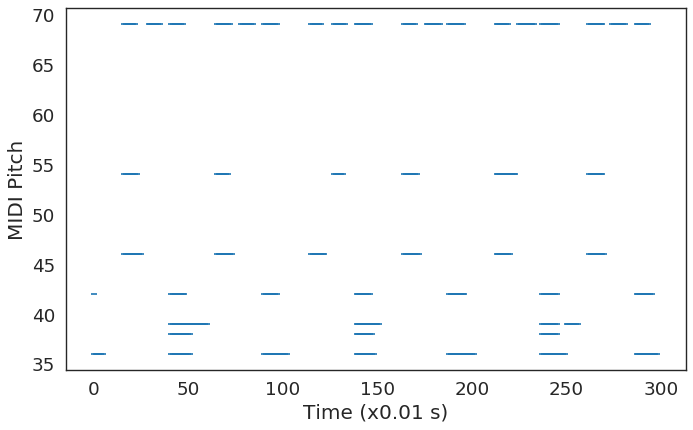

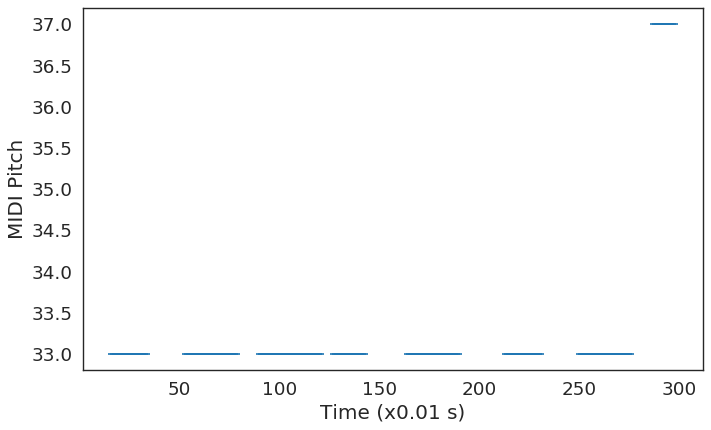

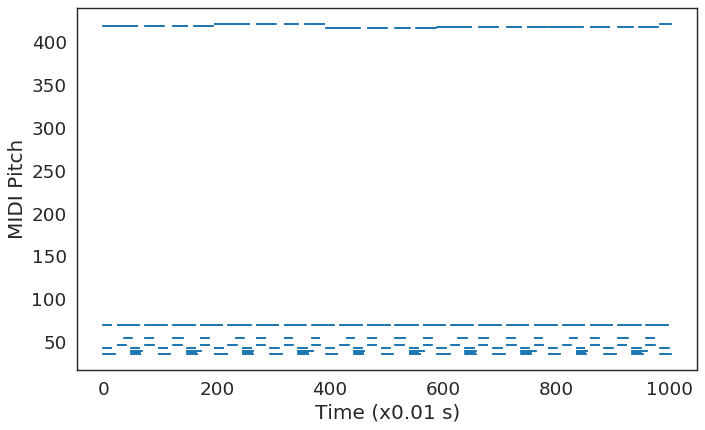

In [27]:
output_X_test = np.argwhere(X_test>0)
plot_data(output_X_test[:,0], output_X_test[:,1])

output_y_test = np.argwhere(y_test>0)
plot_data(output_y_test[:,0], output_y_test[:,1])

output_all_data = np.argwhere(all_data>0)
plot_data(output_all_data[0:5000,0], output_all_data[0:5000,1])

# output_y_all = np.argwhere(y>0)
# plot_data(output_y_all[0:20000,0], output_y_all[0:20000,1])

# output_y_pred = np.argwhere(y_pred>0)
# plot_data(output_y_pred[:,0], output_y_pred[:,1])

# fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
# plt.plot(y_pred, '_', color='red')



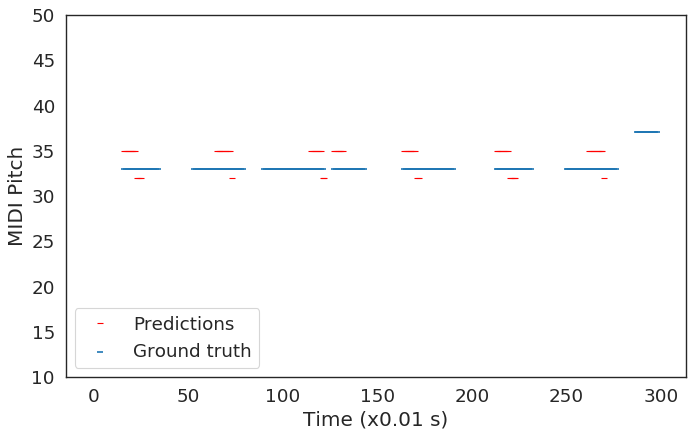

In [28]:
fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(output_y_test[:,0], output_y_test[:,1], marker='_', label='Ground truth')
plt.plot(y_pred, '_', color='red', label='Predictions')
plt.xlabel('Time (x0.01 s)')
plt.ylabel('MIDI Pitch')
plt.ylim(top=50)
plt.ylim(bottom=10)
plt.legend(loc='lower left')
plt.show()

## Bernoulli Naive Bayes 

In [29]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
clf.fit(X_train, y_train_mod)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [30]:
y_pred_nb = clf.predict(X_test)

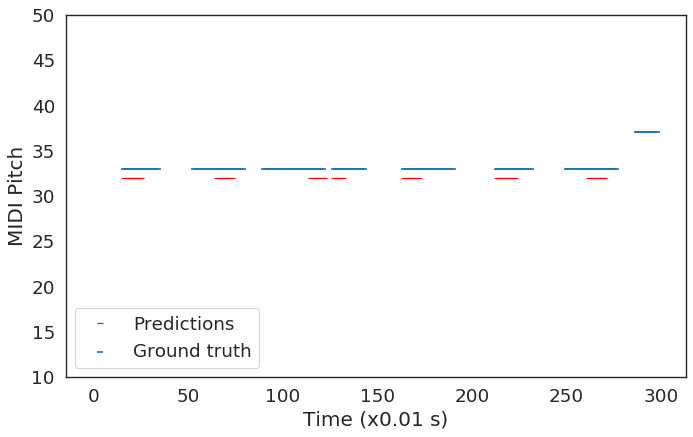

In [31]:
fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
output_y_test = np.argwhere(y_test>0)
plt.scatter(output_y_test[0:5500,0], output_y_test[0:5500,1], marker='_', label='Ground truth')
plt.plot(y_pred_nb[0:6000], '_', color='red', label='Predictions')
plt.xlabel('Time (x0.01 s)')
plt.ylabel('MIDI Pitch')
plt.ylim(top=50)
plt.ylim(bottom=10)
plt.legend(loc='lower left')
plt.show()

## Gaussian Naive Bayes

In [32]:
from sklearn.naive_bayes import GaussianNB
clf_g = GaussianNB()
clf_g.fit(X_train, y_train_mod)

GaussianNB(priors=None, var_smoothing=1e-09)

In [33]:
y_pred_nb_g = clf_g.predict(X_test)

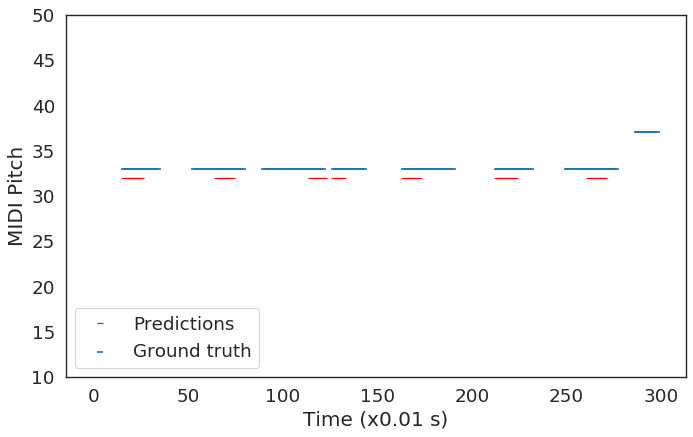

In [34]:
fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
output_y_test = np.argwhere(y_test>0)
plt.scatter(output_y_test[0:5500,0], output_y_test[0:5500,1], marker='_', label='Ground truth')
plt.plot(y_pred_nb_g[0:6000], '_', color='red', label='Predictions')
plt.xlabel('Time (x0.01 s)')
plt.ylabel('MIDI Pitch')
plt.ylim(top=50)
plt.ylim(bottom=10)
plt.legend(loc='lower left')
plt.show()

## Logistic Regression 

In [35]:
from sklearn.linear_model import LogisticRegression
clf_reg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter = 1000).fit(X_train, y_train_mod)


In [36]:
y_pred_reg = clf_reg.predict(X_test)


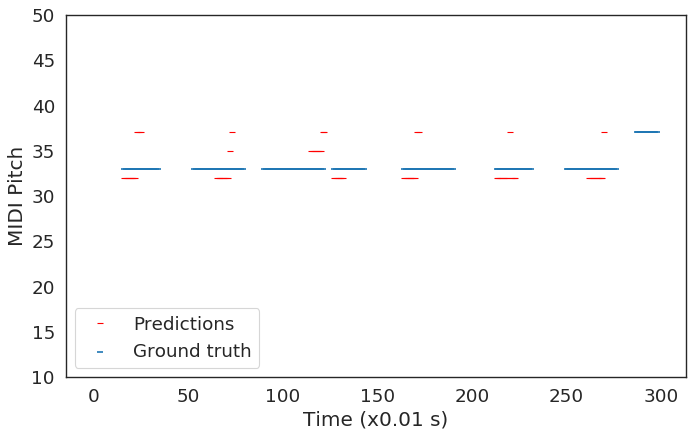

In [37]:
fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
output_y_test = np.argwhere(y_test>0)
plt.scatter(output_y_test[0:5000,0], output_y_test[0:5000,1], marker='_', label='Ground truth')
plt.plot(y_pred_reg[0:5000], '_', color='red', label='Predictions')
plt.xlabel('Time (x0.01 s)')
plt.ylabel('MIDI Pitch')
plt.ylim(top=50)
plt.ylim(bottom=10)
plt.legend(loc='lower left')
plt.show()

In [69]:
y_pred_reg_train = clf_reg.predict(X_train)


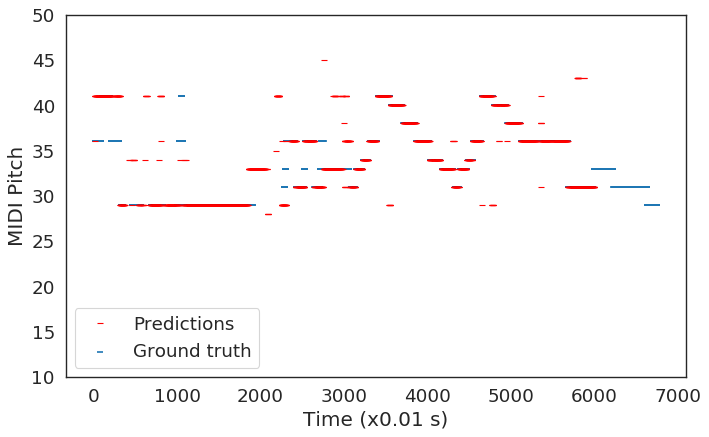

In [78]:
fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
output_y_train = np.argwhere(y_train>0)
plt.scatter(output_y_train[0:5000,0], output_y_train[0:5000,1], marker='_', label='Ground truth')
plt.plot(y_pred_reg_train[0:6000], '_', color='red', label='Predictions')
plt.xlabel('Time (x0.01 s)')
plt.ylabel('MIDI Pitch')
plt.ylim(top=50)
plt.ylim(bottom=10)
plt.legend(loc='lower left')
plt.show()